# Code Assistant

The goal of the demo is to build a code assistant using Langgraph that is able to create a function based on user prompt and recursively improve it until it can be run.

In [1]:
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core langchain_ollama ollama langchain_anthropic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import dependencies

In [2]:
import os, getpass

from pydantic import BaseModel, Field
from pydantic_core import ValidationError
from typing import List, Annotated
from typing_extensions import TypedDict
from operator import add

from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

## Setup API key and LLM models

In [4]:
def _set_gpt_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_gpt_env("OPENAI_API_KEY")

In [6]:
def _set_anthropic_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_anthropic_env("ANTHROPIC_API_KEY")

In [7]:
llm_gpt4o = ChatOpenAI(model="gpt-4o", temperature=0)

In [8]:
llm_claude3_7_sonnet = ChatAnthropic(model="claude-3-7-sonnet-20250219", temperature=0)

In [5]:
#llm_codellama7b = ChatOllama(model="codellama:7b", temperature=0, format="json")

## Set global constants

In [9]:
MAX_ITERATIONS = 5

## Create the code generator subgraph

### Code generation

In [62]:
# Code data model
class Code(BaseModel):
    prefix: str = Field(description="Description of the code generating task.")
    imports: str = Field(description="Import statements.")
    code: str = Field(description="Code block.")

# Initial system and code generation prompt

class_name = "Game"
class_attributes = """window_size: tuple[int, int] = (600, 600)  # The size of the game window
    frame_rate: int = 15  # The frame rate for the game"""
function_task = """Exits the game application."""
function_name = "exit_game"
function_params = "self"
function_result = "None"
function_instructions = """# Pseudocode
        # Quit pygame
        # Exit the application"""

with open('srs.txt', 'r') as f:
    srs = f.read()

with open('dds.txt', 'r') as f:
    dds = f.read()

system_prompt = """You are an experienced Python software developer. You help with function implementation. Always create your code in Python.
The function is part of a software. The software includes classes with attributes and functions. Please inspect the attached system requirements specification
(SRS) and the design document specification (DDS). The SRS details information about how the software should work and the DDS details the classes,
attributes, and functions of the software. Please create the function implementation based on the SRS and DDS such a way that it fits into the
structure of the software. Take into consideration the description of the function, the input parameters and the return value and their types,
and the step-by-step description. Where necessary, import dependencies and use them in the implementation. Be careful, if you use an object of another class,
use the attributes and methods of this object properly. Your solution will be assessed by another LLM.
Strive to create function implementations for which unit tests can be easily created.
SRS:
{}
DDS:
{}""".format(srs, dds)

# If the DDS lacks specific requirement, add the requirement to the prompt as additional requirement. 

code_prompt = """Please help implementing a function in Python based on the prompt provided to you.
The class of the function: {class_name}
The attributes of the class: {attributes}
Description of the function: {task}
Name of the function {function}
Input parameters: {params}
Return parameter: {result}
Step-by-step description of the function: {instructions}
The step-by-step description helps understand the logical flow of the function, but the result must be a function implementation in Python.
Ensure any code you provide can be executed with all imports. Try to write an implementation that meets the following criteria:
- The implementation follows the clean code principle and is easy to maintain and expand.
- The implementation should be secure and provide good performance.
- Include function documentation in a Pythonic way.
Structure your answer as following:
prefix: a description of the function
imports: the list of imports as a string
code: the function implementation as a string
Additional requirement:
-""".format(class_name=class_name, attributes=class_attributes, task=function_task, function=function_name, params=function_params, result=function_result, instructions=function_instructions)

In [12]:
# Create GPT agent
llm_gpt4o = llm_gpt4o.with_structured_output(Code)

In [13]:
# Create Claude agent
llm_claude3_7_sonnet = llm_claude3_7_sonnet.with_structured_output(Code)

In [14]:
def log_code_generation(filename: str, llm: str, iterations: int, error: int):
    with open(f'logs/generation/{filename}.txt', 'a') as f:
        f.write(f'{llm} {iterations} {error}\n')

In [15]:
def log_candidate_selection(filename: str, llm: str):
    with open(f'logs/candidate/{filename}.txt', 'a') as f:
        f.write(f'{llm}')

#### Test run of coding assistant

In [12]:
name = "circle_area"
task = "Help me implement a function that calculates the area of a circle."
params = "r: float"
result =  "area of circle as a float"

circle_area_prompt = code_prompt.format(name=name, task=task, params=params, result=result)

circle_area_function = llm_claude3_7_sonnet.invoke([SystemMessage(content=system_prompt)] + [HumanMessage(content=code_prompt)])
circle_area_function

Code(prefix="This function implements the movement logic for the Snake class in the Snake game. It updates the snake's position based on its current direction, handles growth when the snake eats an apple, and ensures the snake always has at least a head. The function adds a new position for the head in the direction of movement and either removes the tail (if not growing) or keeps it (if growing).", imports='from typing import List, Tuple', code='def move(self) -> None:\n    """\n    Moves the snake in the current direction, growing if necessary.\n    \n    The snake moves by adding a new head position in the direction of movement\n    and removing the tail (unless the snake is growing). This ensures the snake\n    always has at least one body part (the head).\n    \n    Returns:\n        None\n    """\n    # Calculate new head position by adding direction to current head position\n    current_head = self.body[0]\n    new_head = (current_head[0] + self.direction[0], \n                c

In [10]:
circle_area_function = llm_gpt4o.invoke([SystemMessage(content=system_prompt)] + [HumanMessage(content=circle_area_prompt)])
#code = Code.model_validate_json(circle_area_function.content)
#code
circle_area_function

Code(prefix="The function 'move' is responsible for updating the position of the snake based on its current direction. If the snake is set to grow, it will increase its length by adding a new segment at the head's position. Otherwise, it will move by adding a new head and removing the tail segment. This function ensures the snake's movement is consistent with the game's rules.", imports='from typing import List, Tuple', code='class Snake:\n    def __init__(self, initial_position: Tuple[int, int]) -> None:\n        """\n        Initializes the snake with a starting position and initial direction.\n        """\n        self.body: List[Tuple[int, int]] = [initial_position]\n        self.direction: Tuple[int, int] = (0, -1)  # Default direction is north (up)\n        self.grow: bool = False\n\n    def move(self) -> None:\n        """\n        Moves the snake in the current direction, growing if necessary.\n        """\n        # Calculate new head position\n        new_head = (self.body[0]

#### Create graph state

In [16]:
class CodeGeneratorState(TypedDict):
    llm: str
    messages: Annotated[List[AIMessage | HumanMessage | SystemMessage], add] 
    error: int
    generation: Code
    iterations: int

#### Code generation node

In [17]:
def generate_code(state: CodeGeneratorState):
    
    print(f"---{state["llm"]} GENERATING CODE SOLUTION---")

    iterations = state["iterations"]
    iterations += 1

    match state["llm"]:
        case "gpt-4o":
            solution = llm_gpt4o.invoke(state["messages"])
        case "claude3-7-sonnet":
            try:
                solution = llm_claude3_7_sonnet.invoke(state["messages"])
            except ValidationError as e:
                print(f'---{state["llm"]} FAILED TO RETURN STRUCTURED OUTPUT---')
                return {"messages": [AIMessage(content='No generation')], "error": 1, "generation": None, "iterations": iterations}

    ai_message = AIMessage(content="prefix= {}, imports= {}, code= {}".format(solution.prefix, solution.imports, solution.code))

    return {"messages": [ai_message], "error": 0, "generation": solution, "iterations": iterations}

#### Code checking node

In [53]:
def check_code(state: CodeGeneratorState):

    print(f"--- CHECKING CODE SOLUTION of {state["llm"]} ---")

    class CodeCheck(BaseModel):
        score: int = Field(description="Flag to show if the solution is accepted. 1 is accepted, 0 is not accepted.")
        suggestion: str = Field(description="Improvement suggestions.")

    solution_imports = state["generation"].imports
    solution_code = state["generation"].code

    print(f'SOLUTION: {solution_code}')

    llm_gpt4o_checker = ChatOpenAI(model="gpt-4o", temperature=0)
    llm_gpt4o_checker = llm_gpt4o_checker.with_structured_output(CodeCheck)

    checker_system_prompt = """You are a senior Python developer, who helps with peer review. Complete a review of the provided code.
    The code is divided into imports and code.
    During review, consider the following:
    - Is the code formatted correctly? You can ignore indentation issues.
    - Are SOLID principles followed?
    - Are errors handled correctly?
    - Is minimal nesting used?
    - No unnecessary comments?
    - Is the code easy to read?
    - Is the code not repeated?
    - Is the code not too long?
    - Is the code performance acceptable?
    - Is the code secure?
    - Is there sufficient documentation?
    Not all elements of the criteria must be met at all times! For example, if error handling is not necessary, don't force its use!
    The solution doesn't have to be perfect! It is enough, if it lives up to the basic level of the criteria!
    Format your answer as follows:
    score: an integer that determines if the implementation is accepted. Return 1, if the solution is accepted and 0, if the solution is not accepted.
    suggestion: if the solution is not accepted, include a short suggestion here that can be used to improve the code. Otherwise return here 'No suggestions, solution accepted.'"""

    checker_prompt = """
    Imports:
    {}
    Code:
    {}""".format(solution_imports, solution_code)

    checker_response = llm_gpt4o_checker.invoke([SystemMessage(content=checker_system_prompt)] + [HumanMessage(content=checker_prompt)])

    if checker_response.score == 0:
        print("---PEER REVIEW FAILED---")
        update_message = """Your solution was not accepted during peer review. Please try again to create the solution.
        Take into consideration the improvement suggestion and follow the initial user prompt.
        Suggestion:
        {}""".format(checker_response.suggestion)
        print(f"SUGGESTION: {checker_response.suggestion}")
        return {"messages": [HumanMessage(content=update_message)], "error": 1}
    else:
        print("---PEER REVIEW PASSED---")
        return {"error": 0}

#### Conditional edges

In [33]:
def proceed_to_code_check(state: CodeGeneratorState):
    if state["iterations"] == MAX_ITERATIONS and state["error"] == 1:
        print(f"--- {state["llm"]} DECISION: FINISH---")
        log_code_generation(f'{class_name}_{function_name}', state['llm'], state['iterations'], state['error'])
        return "END"
    elif state["error"] == 1:
        print(f"---{state["llm"]} DECISION: RE-TRY SOLUTION---")
        return "generate_code"
    else:
        print(f"---{state["llm"]} DECISION: PROCEED TO CODE CHECK---")
        return "check_code"

In [34]:
def finish(state: CodeGeneratorState):

    if state["error"] == 0 or state["iterations"] == MAX_ITERATIONS:
        print(f"--- {state["llm"]} DECISION: FINISH---")
        log_code_generation(f'{class_name}_{function_name}', state['llm'], state['iterations'], state['error'])
        return "END"
    else:
        print(f"---{state["llm"]} DECISION: RE-TRY SOLUTION---")
        return "generate_code"

#### Create the graph

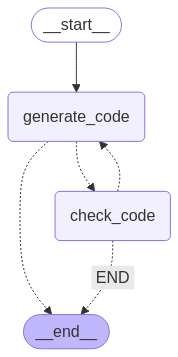

In [54]:
code_generator_builder = StateGraph(CodeGeneratorState)

code_generator_builder.add_node("generate_code", generate_code)
code_generator_builder.add_node("check_code", check_code)

code_generator_builder.add_edge(START, "generate_code")
code_generator_builder.add_conditional_edges("generate_code", proceed_to_code_check)
code_generator_builder.add_conditional_edges("check_code", finish, {"generate_code": "generate_code", "END": END})

code_generator_subgraph = code_generator_builder.compile()

display(Image(code_generator_subgraph.get_graph(xray=1).draw_mermaid_png()))

## Create unit testing subgraph

In [36]:
class TestGeneratorState(TypedDict):
    messages: Annotated[List[AIMessage | HumanMessage | SystemMessage], add]
    test: str

In [37]:
def generate_unit_test(state: TestGeneratorState):

    print("---GENERATING UNIT TESTS")

    llm_gpt4o_tester = ChatOpenAI(model="gpt-4o", temperature=0)

    llm_gpt4o_tester_response = llm_gpt4o_tester.invoke(state["messages"])

    return {"test": llm_gpt4o_tester_response.content}

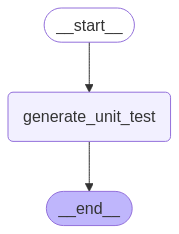

In [38]:
test_generator_builder = StateGraph(TestGeneratorState)

test_generator_builder.add_node("generate_unit_test", generate_unit_test)

test_generator_builder.add_edge(START, "generate_unit_test")
test_generator_builder.add_edge("generate_unit_test", END)

test_generator_subgraph = test_generator_builder.compile()

display(Image(test_generator_subgraph.get_graph(xray=1).draw_mermaid_png()))

## Create the code assistant graph

In [39]:
class CodeAssistantState(TypedDict):
    generations: Annotated[List[Code], add]
    generators: Annotated[List[str], add]
    candidate: int
    test: str

In [40]:
def initiate_code_generators(state: CodeAssistantState):
    responses = []
    responders = []
    
    gpt4o_response = code_generator_subgraph.invoke({"llm": "gpt-4o", "messages": [SystemMessage(content=system_prompt)] + [HumanMessage(content=code_prompt)],
                                                     "iterations": 0})
    claude3_7_sonnet_response = code_generator_subgraph.invoke({"llm": "claude3-7-sonnet", "messages": [SystemMessage(content=system_prompt)] + [HumanMessage(content=code_prompt)],
                            "iterations": 0})

    if gpt4o_response["error"] == 0:
        print('GPT-4o SOLUTION IS CANDIDATE')
        responses.append(gpt4o_response["generation"])
        responders.append('GPT-4o')

    if claude3_7_sonnet_response["error"] == 0:
        print('Claude3-7-Sonnet SOLUTION IS CANDIDATE')
        responses.append(claude3_7_sonnet_response["generation"])
        responders.append('Claude 3.7 Sonnet')
        
    return {"generations" : responses, "generators": responders}

In [41]:
def no_candidate(state: CodeAssistantState):
    if len(list(filter(lambda x: x != None, state["generations"]))) == 0:
        return "END"
    return "select_candidate"

In [42]:
def select_candidate(state: CodeAssistantState):
    
    overseer_system_prompt = "You are an experienced Python developer. You help with choosing the best solution from a list of function candidates."

    overseer_candidate_prompt = """Please help choose the best candidate from the following list. The list contains function implementations with a
    description of the function, the list of imported modules and libraries, and the source code. Every solution is developed in Python. 
    When determining the best candidate, consider the following:\n
    - The function is properly named
    - The parameter list and the return value are easy to understand
    - Preferably there is function documentation
    - The function implementation is clear, robust, and secure\n
    The list of implementations has the following structure:\n
    [X], where X is the number of the candidate starting with 0.
    prefix: <the description of the function>
    imports: <the list of imported modules and libraries as a continuous string>
    code: <the source code as a continuous string>
    As a response, return only the number of the chosen candidate.\n"""

    for num, candidate in enumerate(state["generations"]):
        overseer_candidate_prompt = overseer_candidate_prompt + f"[{num}]\nprefix: {candidate.prefix}\nimports: {candidate.imports}\ncode: {candidate.code}\n"

    llm_gpt4o_overseer = ChatOpenAI(model="gpt-4o", temperature=0)

    overseer_response = llm_gpt4o_overseer.invoke([SystemMessage(content=overseer_system_prompt)] + [HumanMessage(content=overseer_candidate_prompt)])

    log_candidate_selection(f'{class_name}_{function_name}', state['generators'][int(overseer_response.content)])

    return {"candidate": int(overseer_response.content)}

In [43]:
def initiate_test_generators(state: CodeAssistantState):
    candidate = state["generations"][state["candidate"]]
    
    test_generator_system_prompt = """You are an experienced Python tester. You help with writing unit tests for functions.
    Write unit tests for the input function.
    Follow the unit testing best practices:
    - Make sure to cover edge cases.
    - Give the test functions meaningful names.
    - Write readable, simple tests.
    - Write deterministic tests.
    - Test one scenario per test.
    - Write isolated tests, use mocks if necessary.
    - Avoid test interdependence.
    - Avoid active API calls.
    Use the unittest Python module to create the test cases."""
    
    test_generator_prompt = f"""The function is presented as follows:
    prefix = <description of the function>
    imports = <imported modules and libraries>
    code = <function implementation>
    Your response is only the entire test code.
    The function is the following:
    prefix: {candidate.prefix}
    imports: {candidate.imports}
    code: {candidate.code}"""
    
    test_generator_response = test_generator_subgraph.invoke({"messages": [SystemMessage(content=test_generator_system_prompt)] + [HumanMessage(content=test_generator_prompt)]})

    return {"test": test_generator_response["test"]}

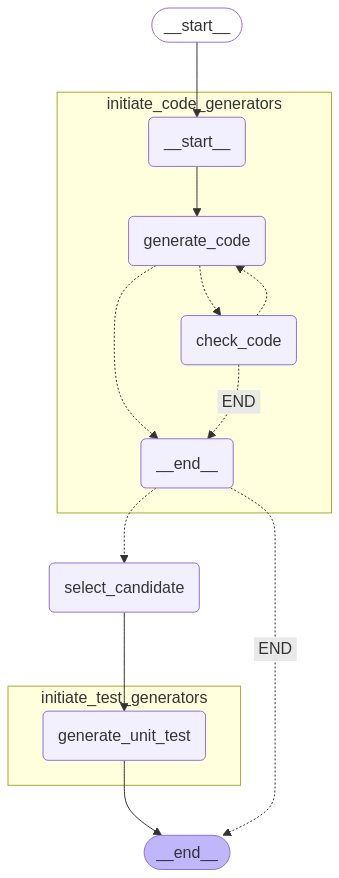

In [55]:
code_assistant_builder = StateGraph(CodeAssistantState)

code_assistant_builder.add_node("initiate_code_generators", initiate_code_generators)
code_assistant_builder.add_node("select_candidate", select_candidate)
code_assistant_builder.add_node("initiate_test_generators", initiate_test_generators)

code_assistant_builder.add_edge(START, "initiate_code_generators")
code_assistant_builder.add_conditional_edges("initiate_code_generators", no_candidate, {"select_candidate": "select_candidate", "END": END})
code_assistant_builder.add_edge("select_candidate", "initiate_test_generators")
code_assistant_builder.add_edge("initiate_test_generators", END)

code_assistant_graph = code_assistant_builder.compile()

display(Image(code_assistant_graph.get_graph(xray=1).draw_mermaid_png()))

In [63]:
code_assistant_response = code_assistant_graph.invoke({"generations": []})

---gpt-4o GENERATING CODE SOLUTION---
---gpt-4o DECISION: PROCEED TO CODE CHECK---
--- CHECKING CODE SOLUTION of gpt-4o ---
SOLUTION: def exit_game(self) -> None:
    """
    Exits the game application by quitting pygame and terminating the program.
    """
    pygame.quit()  # Quit the pygame module
    sys.exit()  # Exit the application
---PEER REVIEW FAILED---
SUGGESTION: 1. The function `exit_game` is defined as a method (indicated by `self`), but there is no class context provided. If this is intended to be a method of a class, ensure that it is placed within a class definition.
2. The docstring should be indented to align with the function body for better readability.
3. The imports are correct and necessary for the functionality provided.
4. Consider adding a check to ensure that `pygame` is initialized before calling `pygame.quit()` to avoid potential errors.
5. The code is simple and performs its intended function effectively, but ensure it is placed within the appropriate cla

In [58]:
code_assistant_response

{'generations': [Code(prefix='The function `start_game` is responsible for initiating and managing the main game loop. It handles user inputs, updates the game state, renders the game, and maintains a consistent frame rate. The function is refactored to adhere to SOLID principles, improve error handling, and enhance readability.', imports='import pygame\nimport sys\n', code='class Game:\n    window_size: tuple[int, int] = (600, 600)  # The size of the game window\n    frame_rate: int = 15  # The frame rate for the game\n\n    def __init__(self):\n        """\n        Initializes the game, setting up the game window and initial state.\n        """\n        pygame.init()\n        self.screen = pygame.display.set_mode(self.window_size)\n        pygame.display.set_caption(\'Snake Game\')\n        self.clock = pygame.time.Clock()\n        self.game_over = False\n        self.snake = Snake((300, 300))  # Initialize snake at the center\n        self.apple = Apple(self.snake.body)  # Initializ

In [64]:
file_name = f'{class_name}_{function_name}.txt'
candidate_idx = code_assistant_response['candidate']
function_prefix = code_assistant_response['generations'][candidate_idx].prefix
function_imports = code_assistant_response['generations'][candidate_idx].imports
function_code = code_assistant_response['generations'][candidate_idx].code
functions_tests = code_assistant_response['test']
with open(f'code/{file_name}', 'w') as file:
    file.write(f'Prefix:\n{function_prefix}\n')
    file.write(f'\nImports:\n{function_imports}\n')
    file.write(f'\nCode:\n{function_code}\n')
    file.write(f'\nTests:\n{functions_tests}')